# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks"

# %cd /content/gdrive/My Drive/Colab Notebooks

In [2]:
#Import all the required libraries
import random
import numpy as np
import pandas as pd
import glob
import pathlib, os
from collections import Counter , OrderedDict
import string
import matplotlib.pyplot as plt
import seaborn as sns
import collections

# tensorflow
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras.preprocessing.image import load_img
import PIL
import PIL.Image
import time

# image processing
from skimage import io
from skimage.transform import rescale, resize

# import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
# sklearn
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=4)

from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
#Import the dataset and read the image into a seperate variable
checkpoint_path = "./checkpoints/train/*.*"

chkpit = glob.glob(checkpoint_path,recursive=True)
chkpit_co = len(chkpit)
print("The total images present in the dataset: {}".format(chkpit_co))
for i in chkpit:
  os.remove(i)

chkpit = glob.glob(checkpoint_path,recursive=True)
chkpit_co = len(chkpit)
print("The total images present in the dataset: {}".format(chkpit_co))

The total images present in the dataset: 15
The total images present in the dataset: 0


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [4]:
#Import the dataset and read the image into a seperate variable
images='Flickr8K/Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
image_count = len(all_imgs)
print(all_imgs[:3])
print("The total images present in the dataset: {}".format(image_count))

['Flickr8K/Images/2201222219_8d656b0633.jpg', 'Flickr8K/Images/3681172959_6674c118d2.jpg', 'Flickr8K/Images/3257107194_f235c8f7ab.jpg']
The total images present in the dataset: 8091


In [5]:
 #Import the dataset and read the text file into a seperate variable
text_file = 'Flickr8K/captions.txt'
def load_doc(filename):
    #your code here
    text = open(filename, 'r', encoding = 'utf-8').read()
    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


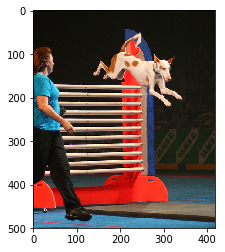

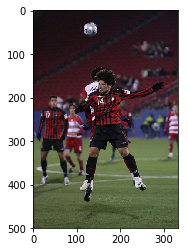

In [6]:
#Visualise a few images
for i in range(3, 7, 2):
    plt.figure()
    img = PIL.Image.open(all_imgs[i])
    plt.imshow(img)

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
# # utility function to clean the caption text
def clean_caption(caption):
    table = str.maketrans('','', string.punctuation)
    desc = caption.split() #create a list of words

    # remove the punctuation from each word
    desc = [word.translate(table) for word in desc]
    
    # remove empty strings and strings like 's and a
    desc = [word.strip() for word in desc if len(word.strip())>1]
    desc = [word.lower() for word in desc if(word.isalpha())] # convert to lower case and pick only alpha numeric 
    return ' '.join(desc)

# def clean_caption(text):
#     return ''.join(e for e in text if e.isalnum() or e == ' ')

In [8]:
# utility token to append <start> and <end>
def appendDelimitingTokes(caption):
    return f'<start> {caption} <end>'

In [9]:
# utility function to generate image path
def getImagePaths(s):
    return s.replace('\\', '/')

In [10]:
# get file name from the path
def getFileName(path):
    return path[len(images)+1:]

In [11]:
# utility function to generate mappings of captions to images as a dictionary with image path as index. 
def MapImageCaptions(doc):
    captionDict = dict()
    text_lines = doc.split('\n')
    # remove the header line
    text_lines.pop(0)
    text_lines = [t for t in text_lines if len(t)>0]
    for line in text_lines:
        dict_index, dict_val = line.split(',', 1)
        dict_index = images + '/' + dict_index
        if dict_index not in captionDict:
            captionDict[dict_index] = list()
        captionDict[dict_index].append(appendDelimitingTokes(clean_caption(dict_val)))
    return captionDict

In [12]:
captionMappings = MapImageCaptions(doc)
len(captionMappings.items())

8091

In [13]:
all_img_vector= list(captionMappings.keys()) #store all the image path here
all_img_id= list(map(getFileName, all_img_vector))#store all the image id here


In [14]:
annotations= captionMappings.values() #store all the captions here

In [15]:
# create a data frame
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
print(df.shape)
df.head(5)

(8091, 3)


,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,[<start> child in pink dress is climbing up se...
1,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,[<start> black dog and spotted dog are fightin...
2,1002674143_1b742ab4b8.jpg,Flickr8K/Images/1002674143_1b742ab4b8.jpg,[<start> little girl covered in paint sits in ...
3,1003163366_44323f5815.jpg,Flickr8K/Images/1003163366_44323f5815.jpg,[<start> man lays on bench while his dog sits ...
4,1007129816_e794419615.jpg,Flickr8K/Images/1007129816_e794419615.jpg,[<start> man in an orange hat starring at some...


In [16]:
## expand the data frame by creating 1 row for each caption
df = (df
 .set_index(['ID','Path'])['Captions']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_2', axis=1)
 .rename(columns={0:'Captions'}))
df.head(5)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> child in pink dress is climbing up set...
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> girl going into wooden building <end>
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl climbing into wooden playh...
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl climbing the stairs to her...
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl in pink dress going into w...


In [17]:
# plot the image along with it's captions. 
def image_desc_plotter(start=10, end=13, image_set=all_img_vector):
    npic = 5
    npix = 224
    target_size = (npix,npix,3)

    count = 1
    fig = plt.figure(figsize=(10,20))
    for image in image_set[start:end]:
        image_id = getFileName(image)
        captions = list(df["Captions"].loc[df["ID"]==image_id].values)
        image_load = load_img(image, target_size=target_size)

        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

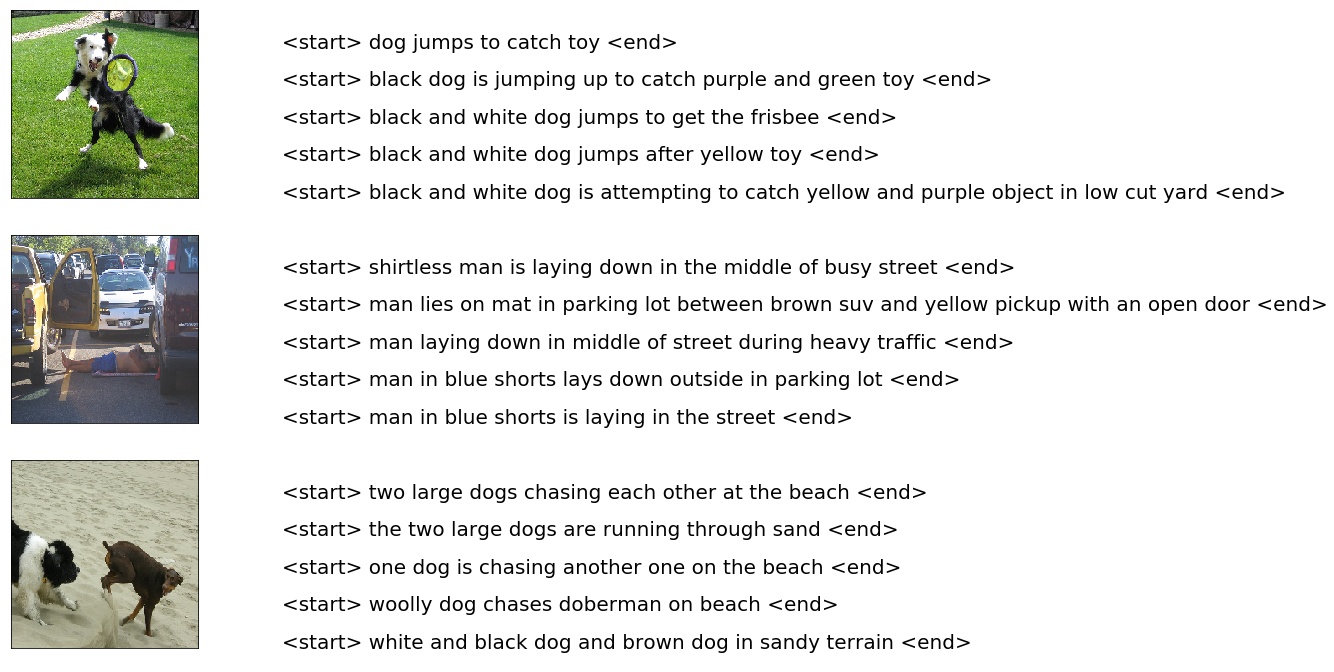

In [18]:
image_desc_plotter(50, 53)

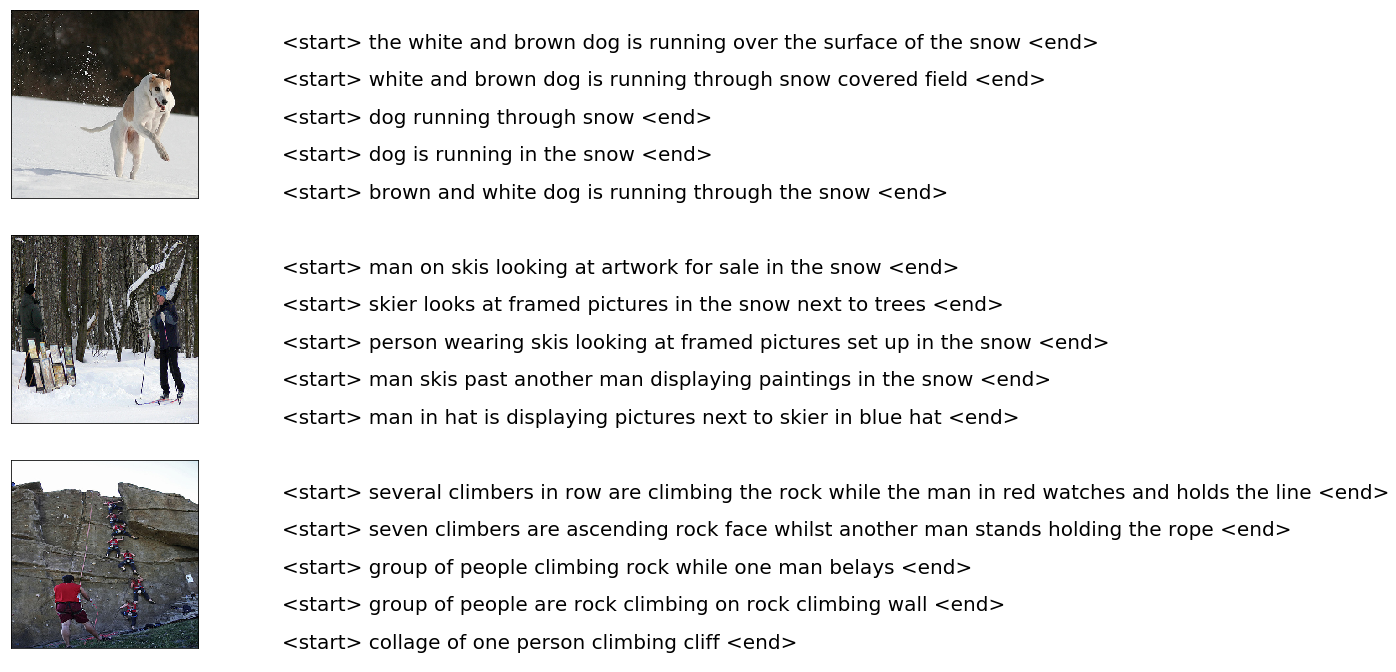

In [19]:
image_desc_plotter()

In [20]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
delimitedAnnotations = df['Captions'].values #GetAllAnnotations(annotations) #write your code here


#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total images present in the dataset: " + str(len(all_img_path)))
print("First delimited annotation " + delimitedAnnotations[0])

Total images present in the dataset: 8091
First delimited annotation <start> child in pink dress is climbing up set of stairs in an entry way <end>


In [21]:
#Create the vocabulary & the counter for the captions

vocabulary= [word for line in delimitedAnnotations for word in line.split()] #write your code here
# val_count
val_count=Counter(vocabulary)


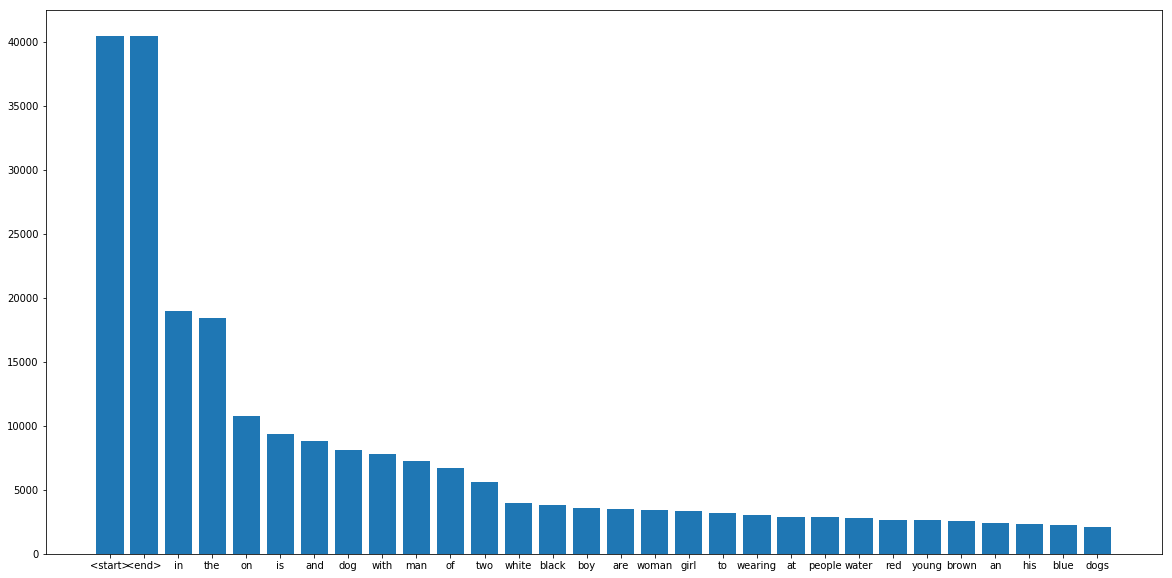

In [22]:
#Visualise the top 30 occuring words in the captions
#write your code here
plt.figure(figsize=(20, 10))
top_words = OrderedDict(val_count.most_common(30))
plt.bar(top_words.keys(), top_words.values())
plt.show()

In [23]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
delimitedAnnotations = df['Captions'].values #GetAllAnnotations(annotations) #write your code here


#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total images present in the dataset: " + str(len(all_img_path)))
print("First delimited annotation " + delimitedAnnotations[0])

Total images present in the dataset: 8091
First delimited annotation <start> child in pink dress is climbing up set of stairs in an entry way <end>


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [24]:
# create the tokenizer
tokenizer = Tokenizer(num_words = 5001 , oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(delimitedAnnotations)

In [25]:
# Create word-to-index and index-to-word mappings.
# word to index mapping
wordIndex = tokenizer.word_index

In [26]:
#index-to-word mappings
indexToWord = tokenizer.index_word

In [27]:
# add the token for padding
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

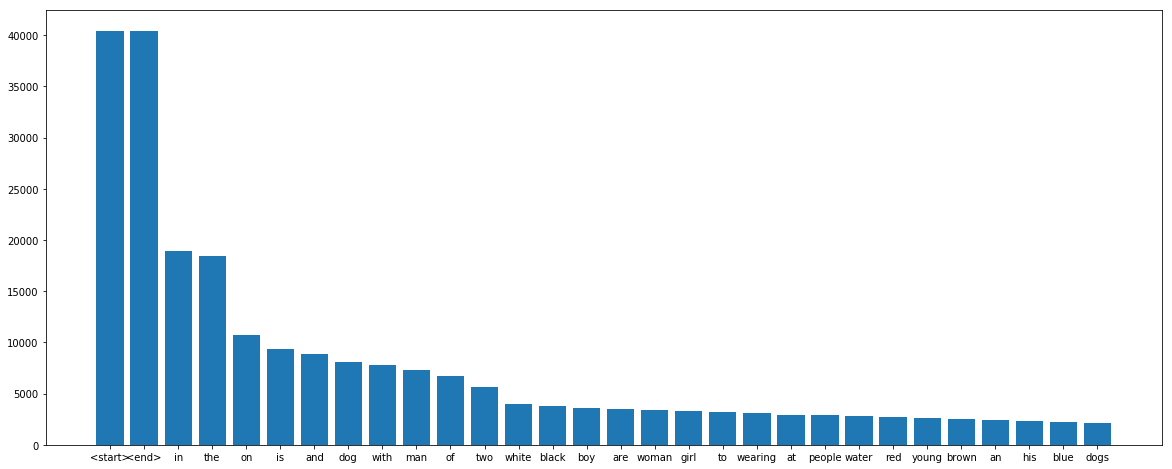

In [28]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
wordCounts = tokenizer.word_counts
plt.figure(figsize=(20, 8))
top_words = OrderedDict(Counter(wordCounts).most_common(30))
plt.bar(top_words.keys(), top_words.values())
plt.show()

In [29]:
# tokenize the captions 
text_sequences = tokenizer.texts_to_sequences(delimitedAnnotations)

In [30]:
# max length of the tokenized caption
MaxLength = max(len(d) for d in text_sequences)
MaxLength

34

In [31]:
# min length of tokenized captions
MinLength = min(len(d) for d in text_sequences)
MinLength

2

In [32]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
cap_vector= pad_sequences(text_sequences, padding='post') #your code here
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 34)


In [33]:
# view the caption vector

In [34]:
# min length is now equal to max length
MinLength = min(len(d) for d in cap_vector)
MinLength

34

In [35]:
# tokenize all the captions. 
df['tokenizedCaptions']  = list(pad_sequences(tokenizer.texts_to_sequences(df['Captions']), padding='post'))
df.head(10)

,ID,Path,Captions,tokenizedCaptions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> child in pink dress is climbing up set...,"[2, 42, 4, 90, 169, 7, 119, 53, 394, 12, 391, ..."
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> girl going into wooden building <end>,"[2, 19, 313, 64, 193, 117, 3, 0, 0, 0, 0, 0, 0..."
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl climbing into wooden playh...,"[2, 40, 19, 119, 64, 193, 2423, 3, 0, 0, 0, 0,..."
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl climbing the stairs to her...,"[2, 40, 19, 119, 5, 391, 20, 60, 2423, 3, 0, 0..."
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl in pink dress going into w...,"[2, 40, 19, 4, 90, 169, 313, 64, 193, 2985, 3,..."
5,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> black dog and spotted dog are fighting...,"[2, 15, 9, 8, 851, 9, 17, 342, 3, 0, 0, 0, 0, ..."
6,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> black dog and tricolored dog playing w...,"[2, 15, 9, 8, 1555, 9, 34, 10, 137, 82, 6, 5, ..."
7,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> black dog and white dog with brown spo...,"[2, 15, 9, 8, 14, 9, 10, 27, 996, 17, 636, 22,..."
8,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> two dogs of different breeds looking a...,"[2, 13, 31, 12, 737, 2641, 88, 22, 137, 82, 6,..."
9,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> two dogs on pavement moving toward eac...,"[2, 13, 31, 6, 719, 795, 318, 137, 82, 3, 0, 0..."


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [36]:
#write your code here
# define the image size
rows = 299
cols = 299

# utility function to read image from given path and process it for inception model
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, file_path

# return image and corresponding caption as passed
def load_image(file_path, cap=None):
    img , _ = process_path(file_path)
    return img, cap

# function to load feature vector saved using imagenet earlier and map it to caption
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [37]:
batch_size=64
BUFFER_SIZE = 100

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [38]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model =  tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [39]:
# write your code to extract features from each image in the dataset
image_vector = sorted(set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(image_vector)
image_dataset = image_dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)


In [40]:
# for img, path in image_dataset:
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#     # we save the features to disk. 
#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         np.save(path_of_feature, bf.numpy())

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [41]:
# get data from dataframe based on keys
def getKeyValueLists(keys):
    data = df.loc[df['ID'].isin(keys)]
    return data['Path'].tolist(), data['tokenizedCaptions'].tolist()

In [42]:
# train test split
train_images, val_images = train_test_split(all_img_id, train_size=0.8, random_state = 42)
len(train_images),len(val_images)

(6472, 1619)

In [43]:
# caption and image path arrays for training data
train_image_idx, train_captions = getKeyValueLists(train_images)
print(len(train_image_idx), len(train_captions))

32360 32360


In [44]:
train_image_idx[0]

'Flickr8K/Images/1000268201_693b08cb0e.jpg'

In [45]:
# caption and image path arrays for validation data
val_image_idx, val_captions = getKeyValueLists(val_images)
print(len(val_image_idx), len(val_captions))

8095 8095


In [46]:
# create train dataset using data api
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_idx, train_captions))

In [47]:
# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          load_image, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)

In [48]:
# view the final data set
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64, 34)


## Test data

In [49]:
# create test dataset using the data api
test_dataset = tf.data.Dataset.from_tensor_slices((val_image_idx, val_captions))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          load_image, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
# shuffle and batch the data
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)

In [50]:
sample_img_batch_test, sample_cap_batch_test = next(iter(test_dataset))
print(sample_img_batch_test.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch_test.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64, 34)


## Train data from feature vector

In [51]:
#  create a tensor from given data
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_idx, train_captions))

In [52]:
# Use map to load the numpy files in parallel. The final dataset will be in  (feature, tokenizedCaption) form
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [53]:
# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [54]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 34)


## Test data

In [55]:
#  create a tensor from given data
test_dataset = tf.data.Dataset.from_tensor_slices((val_image_idx, val_captions))

In [56]:
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [57]:
# Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(batch_size,drop_remainder=True)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [58]:
sample_img_batch_test, sample_cap_batch_test = next(iter(test_dataset))
print(sample_img_batch_test.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch_test.shape) #(batch_size,40)

(64, 64, 2048)
(64, 34)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [59]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(train_image_idx) // batch_size
test_num_steps = len(val_image_idx) // batch_size

### Encoder

In [60]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [61]:
encoder=Encoder(embedding_dim)

### Attention model

In [62]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        return context_vector, attention_weights

### Decoder

In [63]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)  # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    # reset_state
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [64]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [65]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)
dec_input = tf.cast(dec_input, dtype=tf.float32)

In [66]:
predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [67]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [68]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [69]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [70]:
start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#     start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#     # restoring the latest checkpoint in checkpoint_path
#     ckpt.restore(ckpt_manager.latest_checkpoint)

In [71]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        feature = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, feature, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [72]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
      # passing the features through the decoder
          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
          # predictions : (64,8329)
          loss += loss_function(target[:, i], predictions)
        
          predicted_id = tf.argmax(predictions[0])
          # dec_input = tf.expand_dims([predicted_id]*batch_size, 1)

    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [73]:
def test_loss_cal(test_dataset):
    total_loss = 0
    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        # print('test_batch', batch)
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss = total_loss/test_num_steps
    return avg_test_loss

In [74]:
EPOCHS = 10
loss_plot = []
test_loss_plot = []
best_test_loss=100

In [75]:
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    avg_train_loss = total_loss / train_num_steps
    loss_plot.append(avg_train_loss)
    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()
        
    print ('Epoch {} training Loss {:.6f}, test loss : {:.6f}'.format(epoch + 1,total_loss/train_num_steps, best_test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    ckpt_manager.save()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 2.7792
Epoch 1 Batch 100 Loss 1.6176
Epoch 1 Batch 200 Loss 1.5032
Epoch 1 Batch 300 Loss 1.3641
Epoch 1 Batch 400 Loss 1.2766
Epoch 1 Batch 500 Loss 1.0988
Test loss has been reduced from 100.000 to 1.578
Epoch 1 training Loss 1.414347, test loss : 1.577977
Time taken for 1 epoch 271.6929249763489 sec



 10%|█         | 1/10 [04:31<40:46, 271.82s/it]

Epoch 2 Batch 0 Loss 1.6943
Epoch 2 Batch 100 Loss 1.1877
Epoch 2 Batch 200 Loss 1.0402
Epoch 2 Batch 300 Loss 1.0952
Epoch 2 Batch 400 Loss 1.3001
Epoch 2 Batch 500 Loss 1.0873
Test loss has been reduced from 1.578 to 1.475
Epoch 2 training Loss 1.146048, test loss : 1.475427
Time taken for 1 epoch 199.01222395896912 sec



 20%|██        | 2/10 [07:50<33:20, 250.01s/it]

Epoch 3 Batch 0 Loss 1.1936
Epoch 3 Batch 100 Loss 1.0946
Epoch 3 Batch 200 Loss 1.0015
Epoch 3 Batch 300 Loss 0.9691
Epoch 3 Batch 400 Loss 1.1336
Epoch 3 Batch 500 Loss 1.1103
Test loss has been reduced from 1.475 to 1.418
Epoch 3 training Loss 1.050105, test loss : 1.418429
Time taken for 1 epoch 199.63472819328308 sec



 30%|███       | 3/10 [11:10<27:24, 234.94s/it]

Epoch 4 Batch 0 Loss 1.1742
Epoch 4 Batch 100 Loss 1.1191
Epoch 4 Batch 200 Loss 0.9477
Epoch 4 Batch 300 Loss 0.8535
Epoch 4 Batch 400 Loss 1.0270
Epoch 4 Batch 500 Loss 0.9443
Test loss has been reduced from 1.418 to 1.379
Epoch 4 training Loss 0.988215, test loss : 1.378610
Time taken for 1 epoch 199.377831697464 sec



 40%|████      | 4/10 [14:30<22:25, 224.31s/it]

Epoch 5 Batch 0 Loss 1.0798
Epoch 5 Batch 100 Loss 0.9640
Epoch 5 Batch 200 Loss 0.9022
Epoch 5 Batch 300 Loss 0.8879
Epoch 5 Batch 400 Loss 0.9252
Epoch 5 Batch 500 Loss 0.8798
Test loss has been reduced from 1.379 to 1.346
Epoch 5 training Loss 0.939192, test loss : 1.345608
Time taken for 1 epoch 198.89668774604797 sec



 50%|█████     | 5/10 [17:49<18:03, 216.72s/it]

Epoch 6 Batch 0 Loss 1.0720
Epoch 6 Batch 100 Loss 0.8888
Epoch 6 Batch 200 Loss 0.9451
Epoch 6 Batch 300 Loss 0.8622
Epoch 6 Batch 400 Loss 0.8552
Epoch 6 Batch 500 Loss 0.8412
Test loss has been reduced from 1.346 to 1.318
Epoch 6 training Loss 0.896404, test loss : 1.318186
Time taken for 1 epoch 199.70576095581055 sec



 60%|██████    | 6/10 [21:09<14:06, 211.66s/it]

Epoch 7 Batch 0 Loss 0.9631
Epoch 7 Batch 100 Loss 0.8351
Epoch 7 Batch 200 Loss 0.8304
Epoch 7 Batch 300 Loss 0.7639
Epoch 7 Batch 400 Loss 0.8487
Epoch 7 Batch 500 Loss 0.7595
Test loss has been reduced from 1.318 to 1.293
Epoch 7 training Loss 0.857543, test loss : 1.293468
Time taken for 1 epoch 199.39569664001465 sec



 70%|███████   | 7/10 [24:28<10:24, 208.02s/it]

Epoch 8 Batch 0 Loss 0.8741
Epoch 8 Batch 100 Loss 0.8247
Epoch 8 Batch 200 Loss 0.8158
Epoch 8 Batch 300 Loss 0.7932
Epoch 8 Batch 400 Loss 0.8319
Epoch 8 Batch 500 Loss 0.7577
Test loss has been reduced from 1.293 to 1.272
Epoch 8 training Loss 0.823746, test loss : 1.272209
Time taken for 1 epoch 199.44411396980286 sec



 80%|████████  | 8/10 [27:48<06:50, 205.48s/it]

Epoch 9 Batch 0 Loss 0.8863
Epoch 9 Batch 100 Loss 0.8276
Epoch 9 Batch 200 Loss 0.7487
Epoch 9 Batch 300 Loss 0.8158
Epoch 9 Batch 400 Loss 0.7643
Epoch 9 Batch 500 Loss 0.6676
Test loss has been reduced from 1.272 to 1.252
Epoch 9 training Loss 0.793559, test loss : 1.251759
Time taken for 1 epoch 199.65968799591064 sec



 90%|█████████ | 9/10 [31:07<03:23, 203.78s/it]

Epoch 10 Batch 0 Loss 0.9208
Epoch 10 Batch 100 Loss 0.8038
Epoch 10 Batch 200 Loss 0.7692
Epoch 10 Batch 300 Loss 0.6890
Epoch 10 Batch 400 Loss 0.8379
Epoch 10 Batch 500 Loss 0.7094
Test loss has been reduced from 1.252 to 1.235
Epoch 10 training Loss 0.764749, test loss : 1.235139
Time taken for 1 epoch 199.2624113559723 sec



100%|██████████| 10/10 [34:27<00:00, 202.46s/it]


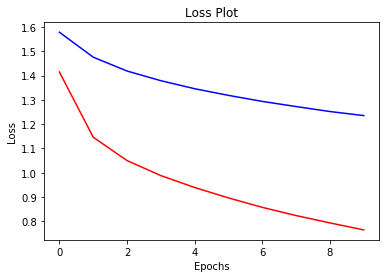

In [76]:
plt.plot(loss_plot, color = 'red')
plt.plot(test_loss_plot, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [77]:
attention_features_shape = 64 #assign from relevant variable above
def evaluate(image):
    attention_plot = np.zeros((MaxLength, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(process_path(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(MaxLength):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        
        #map the id to the word from tokenizer and append the value to the result list
        predicted_word = tokenizer.index_word[predicted_id]
        result.append(predicted_word)
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [78]:
# def plot_attmap(caption, weights, image):
#   # caption = result, weights = attentionplot, image= image
#     fig = plt.figure(figsize=(10, 10))
#     temp_img = np.array(PIL.Image.open(image))
    
#     len_cap = len(caption)
#     for cap in range(len_cap):
#         weights_img = np.reshape(weights[cap], (8,8))
#         # weights_img = np.array(PIL.Image.fromarray(weights_img).resize((224, 224), PIL.Image.LANCZOS))
        
#         ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
#         ax.set_title(caption[cap], fontsize=15)
        
#         img=ax.imshow(temp_img)
        
#         ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
#         ax.axis('off')
#     plt.subplotsa_adjust(hspace=0.2, wspace=0.2)
#     # plt.tight_layout()
#     plt.show()

In [79]:

def plot_attmap(result,  attention_plot , image):
    temp_image = np.array(PIL.Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [80]:
from nltk.translate.bleu_score import sentence_bleu

In [81]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [82]:
rid = np.random.randint(0, len(val_image_idx))
#test_image = './images/413231421_43833a11f5.jpg'
test_image = val_image_idx[rid]

#real_caption = '<start> black dog is digging in the snow <end>'
real_caption = ' '.join([tokenizer.index_word[i] for i in val_captions[rid] if i not in [0]])
real_caption=filt_text(real_caption)      

print(rid, test_image, real_caption)

3866 Flickr8K/Images/3072172967_630e9c69d0.jpg four basketball players in action


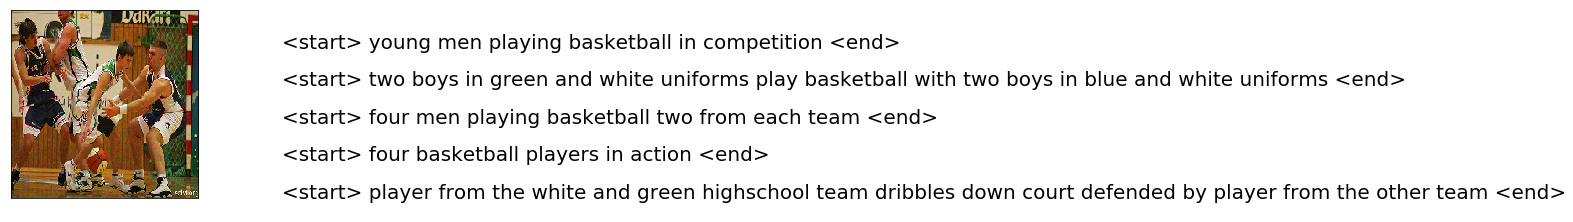

In [83]:
# view the test image and it's captions
image_desc_plotter(rid, rid+1, val_image_idx)

BELU score: 0
Real Caption: four basketball players in action
Prediction Caption: young player are trying to get fight for the player play game


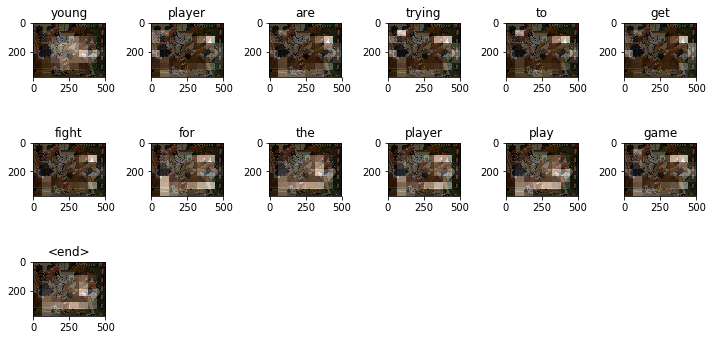

In [84]:
# predict using greedy search
result, attention_plot,pred_test = evaluate(test_image)
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

# calculate bleu score 
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))#set your weights)
print(f"BELU score: {score*100}")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

In [85]:
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((MaxLength, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(process_path(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < MaxLength:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption



In [86]:
# evaluate using beam search
captions=beam_evaluate(test_image, 7)
print(captions)
candidate = captions.split()
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")
print ('Real Caption:', real_caption)


basketball
BELU score: 2.73208551083605e-154
Real Caption: four basketball players in action
